# Finite Elements Method - Implementation

### The problem

Find $u \in V_h \subset V$ s.t. 
$$a(u,v) = \int_\Omega fv \qquad \forall v \in V_h$$

We consider a basis $\{v_i\}_{i=0}^{N-1}$ of $V_h$, then we are able to write each $v \in V_h$ as $v = \sum_i \alpha_i v_i$. 

Since $a(u,v) = \int_\Omega u'v'$, replacing $u,v$ we obtain 
$$a(u,v) = \sum_i \sum_j \alpha_i \beta_j a(v_i, v_j) \qquad \qquad u = \sum_i \alpha_i v_i, \qquad v = \sum_j \beta_j v_j$$

Obtaining the matrix $A_{ij} = a(v_i, v_j)$ would then allow us to compute easily $a(u,v) \forall v \in V_h$. For the same reason, defining $f_i := \int_\Omega f v_i$ we get that
$$\int_\Omega fv = \sum_i \gamma_i \int_\Omega f_i \qquad v = \sum_j \beta_j v_j$$

Therefore, given a basis we would like to compute
$$f_i := \int_\Omega f v_i$$
and 
$$A_{ij} := \int_\Omega v_i' v_j'$$
Our domain $\Omega$ is a segment $[a,b]$ since we consider the 1D case. We split the segment in M segments (M+1 vertices). 

### The mapping trick

We want to subdivide the domain $\Omega$ in such a way that each sub-domain $T_k$ is obtainable via an affine mapping from a reference sub-domain $\hat{T}$. That is, $\forall k T_k = F_k(\hat{T})$. This is going to add some overhead since the derivatives becomes somehow more cluttered, but this has the invaluable computational advantage that many quantities are computed only once for the entire domain $\Omega$.

We denote the number of elements in which $\Omega$ is subdivided with $M$.

$$\begin{align}
\int_\Omega g &= \sum_{k=0}^{M-1} \int_{T_k} g\\
&= \sum_{k=0}^{M-1} \int_{\hat{T}} (g \circ F_k) J
\end{align}$$

where $J_k = \det \frac{\partial F_k}{\partial \hat{x}}$. We can now complete the integration using a quadrature formula having the form:
$$\int f = \sum_j f(x_j) w_j$$

The complete formula, using $N_q$ quadrature points with weights $w_j$, is then:
$$\int_\Omega g = \sum_{k=0}^{M-1} \sum_{j=0}^{N_q-1} (g \circ F_k)(\hat{x}) w_j J_k d\hat{x}$$

### Renumbering and other amenities

We define a matrix 
$$P_{ki\alpha} = \begin{cases} 1 &v_i(F_k(\hat{x})) = \hat{V}_\alpha(\hat{x}) \qquad \forall \hat{x} \in \hat{T}\\
0 &\text{otherwise}\end{cases}$$

That is, a way to connect basis functions of $T_k$ and those of $\hat{T}$ which are in "some sense" compatible. This is allowed because we expect basis of $T_k$ to be derived (in some way) from those of $\hat{T}$.

In this way we can develop on the following integral:
$$\begin{align}
f_i = \int_\Omega f v_i &= \sum_k \int_{T_k} f v_i\\
&= \sum_k \int_{\hat{T}} ((f v_i) \circ F_k) (\hat{x}) J_k d\hat{x}\\
&= \sum_k \int_{\hat{T}} (f \circ F_k)(\hat{x}) (v_i \circ F_k)(\hat{x}) J_k d\hat{x}\\
&= \sum_\alpha \sum_k \int_{\hat{T}} (f \circ F_k)(\hat{x}) P_{ki\alpha} \hat{v}_\alpha(\hat{x}) J_k d\hat{x}\\
\end{align}$$

where only one of the summation elements spawned by $\sum_\alpha$ in the last line is going to be different than zero.

For what concerns the other quantity of interest, i.e. the matrix $a(v_i,v_j)$, we first observe that (chain rule)
$$\frac{\partial}{\partial\hat{x}} (v_i \circ F_k) = \left[\left(\frac{\partial}{\partial\hat{x}} v_i\right) \circ F_k\right]\left(\frac{\partial}{\partial\hat{x}} F_k\right)^t$$

Note that $\frac{\partial}{\partial\hat{x}} (v_i \circ F_k) = \hat{\nabla} \hat{v}_\alpha$ for some $\alpha$, and we also set $\mathbb{F}_k^T := \left(\frac{\partial}{\partial\hat{x}} F_k\right)^t$

Then we have
$$\nabla v_i \circ F_k = \hat{\nabla} \hat{v}_\alpha (\mathbb{F}_k^T)^{-1}$$

Note that we replaced the dependency on $i$ (index on the basis of $T_k$) with a dependency on $\alpha$ (index on the basis of $\hat{T}$) and a dependency on $k$, which can be computed a single time for each element. We can use this as follows in the computation of $a(v_i,v_j) := A_{ij}$:
$$\begin{align}
A_{ij} = \int_\Omega v_i' v_j' &= \sum_k \int_{T_k} v_i' v_j'\\
&= \sum_k \int_{\hat{T}} (v_i' v_j' \circ F_k)(\hat{x}) J_k d\hat{x}\\
&= \sum_k \int_{\hat{T}} (v_i' \circ F_k)(\hat{x}) (v_j' \circ F_k)(\hat{x}) J_k d\hat{x}\\
&= \sum_{\alpha,\beta} \sum_k \int_{\hat{T}} P_{ki\alpha} \left(v_\alpha'(\mathbb{F}_k^T)^{-1}\right)(\hat{x}) P_{kj\beta} \left(v_\beta'(\mathbb{F}_k^T)^{-1}\right)(\hat{x}) J_k d\hat{x}\\
\end{align}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

In [2]:
# extremes of the domain
a = 0
b = 1

# number of elements (the k-th element is obtained via mapping(That, k))
M = 5

# number of support points used to construct the lagrange basis on That
degree = 2
# number of quadrature points used to integrate on That
n_quadrature_points = 2*degree+1
# support points on That
reference_vertices = np.linspace(0,1,degree+1)

N = M*degree+1

# vertices of the triangulation of Omega
vertices = np.linspace(a,b,M+1)

We now define a function to map values from the reference domain to one of our $M$ elements:

In [3]:
# maps values from That to the k-th element
def mapping(q, i):
    return lambda x: q[i] + x*(q[i+1]-q[i])

# this is the derivative of `mapping`
def mapping_J(q,i):
    return (q[i+1] - q[i])

We demonstrate the way those functions work with a plot:

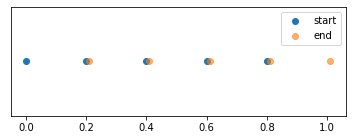

In [4]:
start_segment = np.array([mapping(vertices, i)(0) for i in range(M)])
end_segment = np.array([mapping(vertices, i)(1) for i in range(M)])

plt.figure(figsize=(6,2))
plt.scatter(start_segment, np.zeros_like(start_segment), label='start')
plt.scatter(end_segment + 1.e-2, np.zeros_like(end_segment), label='end', alpha=0.6)
plt.legend()
plt.yticks([],[])
plt.show()

### Basis functions on $\widehat{T}$

We are going to use Lagrange basis functions on $\widehat{T}$, therefore we define a function to compute the basis:

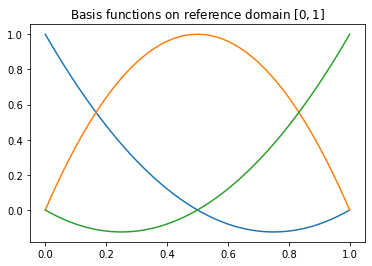

In [5]:
# we are going to use lagrange basis as a function basis on the reference sub-domain
def lagrange_basis(q, i):
    return lambda x: np.prod([(x-q[j]) / (q[i]-q[j]) for j in range(len(q)) if i != j], axis=0)

def lagrange_basis_derivative(q,i):
    t = sym.var('t')
    return sym.lambdify(t, lagrange_basis(q,i)(t).diff(t))

x = np.linspace(0,1,51)
[plt.plot(x, lagrange_basis(reference_vertices, i)(x)) for i in range(degree+1)]
plt.title('Basis functions on reference domain $[0,1]$')
plt.show()

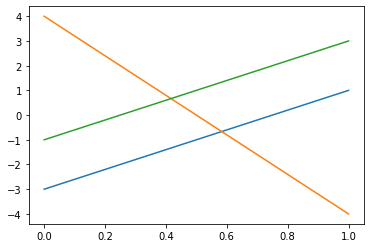

In [6]:
Vp = np.array([lagrange_basis_derivative(reference_vertices, i)(x) for i in range(degree+1)]).T
plt.plot(x,Vp);

### Integration by quadrature formula

The following is an interpolatory quadrature formula on $\widehat{T} = [0,1]$. This (the reference domain) is the **only** place where we're going to integrate.

In [7]:
q,w = np.polynomial.legendre.leggauss(n_quadrature_points)
q = (q+1)/2
w = w/2

# integrate f on [0,1]
def integrate(f):
    return np.dot(w, f(q))

def func1(x):
    return x

integrate(func1)

0.5

### Missing derivatives

Since the following equality holds:
$$\nabla v_i \cdot F_k = \widehat{\nabla} \widehat{V_\alpha} F^{-T}$$

we would like to compute $\widehat{\nabla} \widehat{V_\alpha}$, which could then be used in place of $\nabla v_i \cdot F_k$ in our integrations. Note that $F^{-T} = (F^T)^{-1} = ((\frac{\partial}{\partial \widehat{x}} F_k)^T)^{-1}$, which is the derivaive of the mapping (see the function `mapping_J`).

### Continuity of basis functions

We fixed the number of basis functions for each element. However we would like to have some kind of continuity on those functions at the boundary of each element. If we have three Lagrange functions on an interval, with equispaced vertices we are going to have only one function which is not zero for each node. 

This means that 2/3 of the functions are not "problematic" (we can set them to zero for the rest of the elements, this preserves continuity). However that one function whose non-zero node is at boundary must "link" with one of the basis functions of the next elements (the first one, since it is the only basis function whose non-zero node is the first point belonging to the next element). This is why we are going to construct the matrix $P$ as explained below.

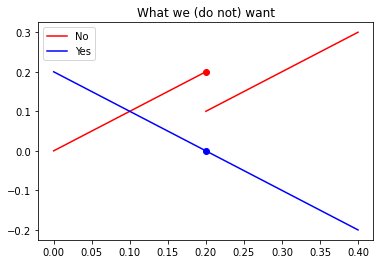

In [8]:
plt.plot(np.linspace(0,0.2,3), np.linspace(0,0.2,3), 'r')
plt.plot(np.linspace(0.2,0.4,3), np.linspace(0.2,0.4,3)-0.1, 'r', label='No')
plt.scatter([0.2], [0.2], color='r')

plt.plot(np.linspace(0,0.2,3), 0.2-np.linspace(0,0.2,3), 'b')
plt.plot(np.linspace(0.2,0.4,3), 0.2-np.linspace(0.2,0.4,3), 'b', label='Yes')
plt.scatter([0.2], [0], color='b')

plt.title('What we (do not) want')
plt.legend();

We want basis functions which are **locally** polynomials (in the elements) that are globally continous. We want polynomials because we know how to integrate them.

In [9]:
P = np.zeros((M,degree+1), dtype=int)
for k in range(M):
    start=k*degree
    P[k] = np.array(range(start,start+degree+1))
P

array([[ 0,  1,  2],
       [ 2,  3,  4],
       [ 4,  5,  6],
       [ 6,  7,  8],
       [ 8,  9, 10]])

As you can see the first basis function of the second element is the last basis function of the first element.

We now define a matrix operator which contains our basis functions in each segment.

In [10]:
# B is such that B[k][x][i] is the i-th basis evaluated at x in segment k
B = np.zeros((M, len(x), N))

for k in range(M):
    B[k,:,P[k]] = np.array([lagrange_basis(reference_vertices, i)(x) for i in range(degree+1)])

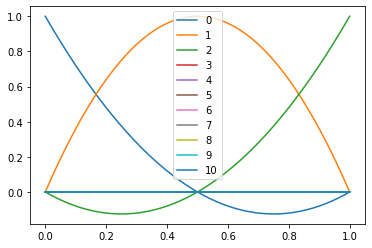

In [11]:
for i in range(B.shape[2]):
    plt.plot(x,B[0,:,i], label=i)
plt.legend()
plt.show()

In [12]:
X = np.array([mapping(vertices, k)(x) for k in range(M)])
X.shape, B.shape

((5, 51), (5, 51, 11))

(255,)


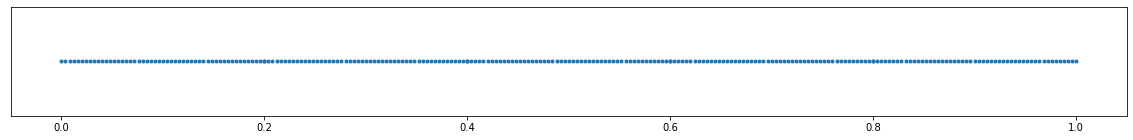

In [13]:
X2 = X.flatten()
print(X2.shape)

plt.figure(figsize=(20,2))
plt.scatter(X2, np.zeros_like(X2), marker='.')
plt.yticks([], [])
plt.show()

(255, 11)


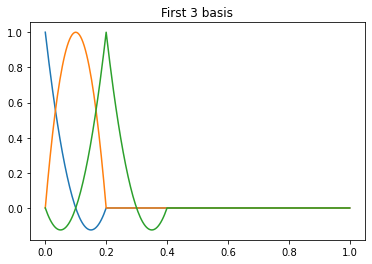

In [14]:
B2 = B.reshape((len(X2), -1))
print(B2.shape)

plt.plot(X2, B2[:,:3])
plt.title('First 3 basis');

### Interpolation using $B$

We now try to use the basis functions we obtained for $[0,1]$ (and stored in `B`) in order to interpolate the Runge function. Note that the interpolant is going to be piece-wise polynomial of degree 2.

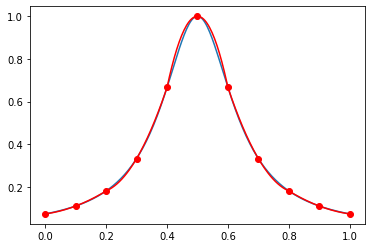

In [15]:
support_points = np.linspace(a,b,N)

def runge(x):
    return 1/(1+50*(x-.5)**2)

plt.plot(X2, runge(X2))
plt.plot(support_points, runge(support_points), 'ro')
# interpolation with Lagrange does not require inverting a matrix
plt.plot(X2, B2.dot(runge(support_points)), 'r');

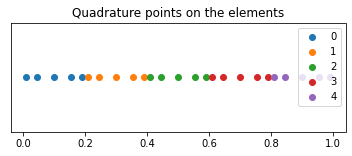

In [16]:
# for each element, these are the Gauss quadrature points which we are going to use
# in order to integrate
Q = np.array([mapping(vertices,element_idx)(q) for element_idx in range(M)])

plt.figure(figsize=(6,2))
for i in range(Q.shape[0]):
    plt.scatter(Q[i], np.zeros_like(Q[i]), label=i)
plt.legend()
plt.yticks([],[])
plt.title('Quadrature points on the elements')
plt.show()

In [17]:
# maps the weights x Jacobian of the transformation
JxW = np.array([mapping_J(vertices,element_idx)*w for element_idx in range(M)])
JxW.shape

(5, 5)

### Wrong way: integration

In [18]:
Bq = np.zeros((M, n_quadrature_points, N))
Vq = np.array([lagrange_basis(reference_vertices, i)(q) for i in range(degree+1)]).T

for k in range(M):
    Bq[k,:,P[k]] = Vq.T
    
Xq = Q.flatten()
Bq = Bq.reshape((len(Xq),-1))

JxWq = JxW.flatten()

In the following definition we integrate over the quadrature points. So we are summing over $q$ the values $v_i(x_q) v_j(x_q)$ multiplied by $w_q$ (weight) and $J_q$. The result is matrix which represents $\int_\Omega v_i v_j$.

In [19]:
MassMatrix = np.einsum('qi,qj,q', Bq,Bq,JxWq)
MassMatrix.shape

(11, 11)

We now compute $f_i = \int_{\Omega} f v_i$:

In [20]:
mass_rhs = np.einsum('qi,q,q', Bq, runge(Xq), JxWq)
mass_rhs.shape

(11,)

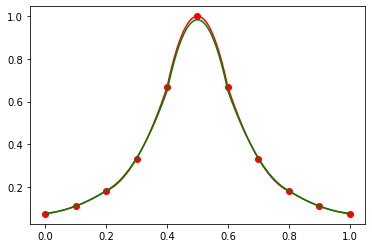

In [21]:
u_projection = np.linalg.solve(MassMatrix, mass_rhs)
plt.plot(support_points, runge(support_points), 'ro')
plt.plot(X2, B2.dot(runge(support_points)), 'r')
plt.plot(X2, B2.dot(u_projection), 'g');

In [22]:
Bq.shape

(25, 11)

### Right way: integration

Note that the shape of `Bq` becomes huge for more interesting problems. Since it is a global matrix, it makes more sense to compute the integral piece by piece instead of computing gloabl quantities. It is equivalent in terms of computational complexity, but it is not the same from a memory perspective.

We are going to exploit the fact that `Vq`, which is definied above as

In [23]:
Vq = np.array([lagrange_basis(reference_vertices, i)(q) for i in range(degree+1)])

Is the same for all the elements.

In [24]:
Bprimeq = np.zeros((M, n_quadrature_points, N))
Vprimeq = np.array([lagrange_basis_derivative(reference_vertices, i)(q) for i in range(degree+1)]).T

for k in range(M):
    Bprimeq[k,:,P[k]] = Vprimeq.T / mapping_J(vertices, k)
    
Bprimeq = Bprimeq.reshape((len(Xq),-1))

We now compute the stiffness matrix.

Why is it not well conditioned? Because in this case we're not looking for functions in $H^1_0$, the boundary condition changes. We are now requiring that the derivative (and not the actual function) vanishes on the boundary. This is true for an infinite number of functions (e.g. constants), therefore the problem is not well conditioned.

In [25]:
StiffnessMatrix = np.einsum('qi,qj,q', Bprimeq, Bprimeq, JxWq)
# condition number should be terrible
np.linalg.cond(StiffnessMatrix)

3.4969317210165816e+16

In order to fix this problem we fix the matrix. We set to zero the first and last rows, and change the values of $[0,0], [-1,-1]$. Note that we're imposing a different boundary condition.

In [26]:
StiffnessMatrix[0,:] = StiffnessMatrix[-1,:] = 0
StiffnessMatrix[0,0] = StiffnessMatrix[-1,-1] = 1
np.linalg.cond(StiffnessMatrix)

129.9069289964899

In [27]:
def rhs_function(x):
    return np.sin(2*np.pi*x)

rhs = mass_rhs = np.einsum('qi,q,q', Bq, rhs_function(Xq), JxWq)
rhs[0] = rhs[-1] = 0

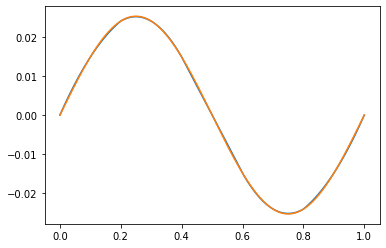

In [28]:
u = np.linalg.solve(StiffnessMatrix, rhs)
plt.plot(X2, B2.dot(u));
plt.plot(X2, rhs_function(X2) / (4*np.pi**2));